In [2]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [3]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.932722,0.806913,0.653998,0.860533,0.837016,1.0,0.550415,0.000000,0.778617,0.940755
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.692339,0.578107,0.619998,0.0,0.000000,0.000000,0.607899,0.206271
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.000000,0.505180,0.644769,0.603195,0.756754,0.0,0.350566,0.000000,0.899508,0.014040
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.000000,0.000000,0.131632,0.053179,0.774455,0.0,0.000000,0.000000,0.528882,0.305806
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.000000,0.000000,0.085440,0.761822,0.860355,0.0,0.000000,0.000000,0.604102,0.014040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.000000,0.000000,0.149005,0.740343,0.641698,0.0,0.000000,0.694951,0.485461,0.300471
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.000000,0.000000,0.229358,0.640000,0.731908,0.0,0.422815,0.096205,0.502320,0.615334
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.000000,0.000000,0.211405,0.797333,0.896369,0.0,0.234352,0.000000,0.496177,0.402714


In [4]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.00000,0.0,0.016890,0.754178,0.816832,0.0,0.214180,0.000000,0.627881,0.014040
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.00000,0.0,0.380373,0.659297,0.789071,0.0,0.000000,0.296100,0.763348,0.354178
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.68115,0.0,0.127947,1.009412,0.582660,0.0,0.000000,0.473139,0.277717,0.014040
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.00000,0.0,0.203518,0.723574,0.696147,0.0,0.000000,0.000000,0.646765,0.450394
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.00000,0.0,0.214416,0.496175,0.803259,0.0,0.236722,0.000000,0.534480,0.304870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.00000,0.0,0.357494,0.782257,0.591442,0.0,0.000000,0.431213,0.465159,0.540147
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.00000,0.0,0.418615,0.949858,0.559052,0.0,0.269991,0.410777,0.361163,0.561191
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.00000,0.0,0.105689,0.683222,0.878635,0.0,0.182111,0.650452,0.568842,0.398252


In [5]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [6]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [7]:
# compound_model = keras.models.load_model('cd_clf')

In [8]:
# compound_model.summary()

## SHAP evaluation

In [9]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [10]:
import objects

In [11]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


link.f
link.f
link.f
link.f


## Calculate SHAP values

In [12]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [13]:
# shap_values

## Save SHAP values

In [14]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [15]:


with open("../data/models/shap/all_indep_2p11", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [16]:
shap_values = shap_values[0]


In [17]:
# for i in range(3):
#     shap_values[i] /= 100

In [18]:
shap_values

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.38537902, -0.58951254],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 2.72911613, -3.07189083, -1.03219905, ..., -1.75058844,
         -3.09130665, -2.80057304],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.48289274,  0.        , ..., -0.44628993,
          0.        ,  0.        ],
        [ 0.05631593,  0.        ,  0.27271772, ..., -0.20228209,
         -0.35141287,  0.59480718]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  1.45170425,  2.03695117, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [19]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 221)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [20]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.0,0.0,0.155668,0.723766,0.785738,0.0,0.0,0.236732,0.678505,0.727315


In [21]:
gmm_model_get_prediction_ae(patient)[0]

array([2.10208717e-56, 1.38514946e-01, 8.61485054e-01])

In [22]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.10208717e-56 1.38514946e-01 8.61485054e-01]
Predicted class: 2


#### Control

In [23]:
import shap

In [24]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [25]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [26]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [27]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

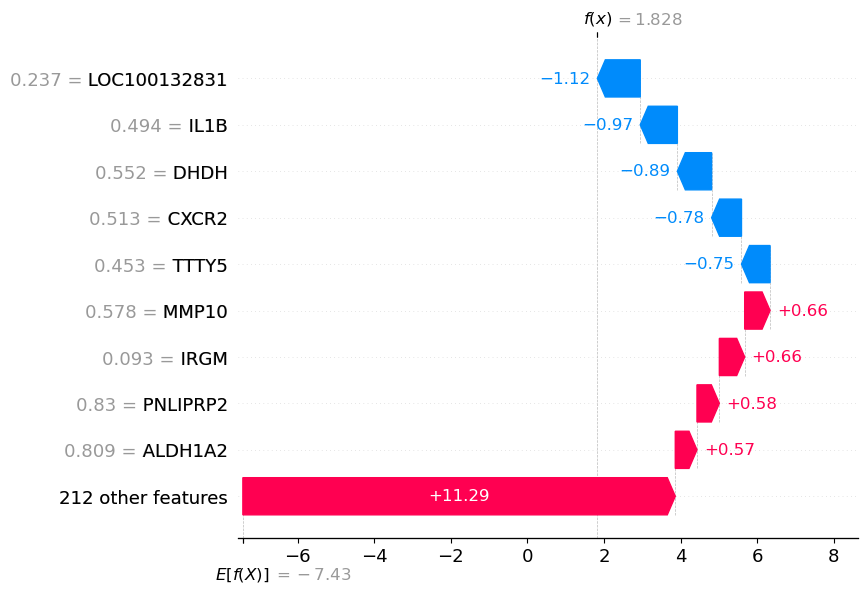

In [28]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [29]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [30]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [31]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

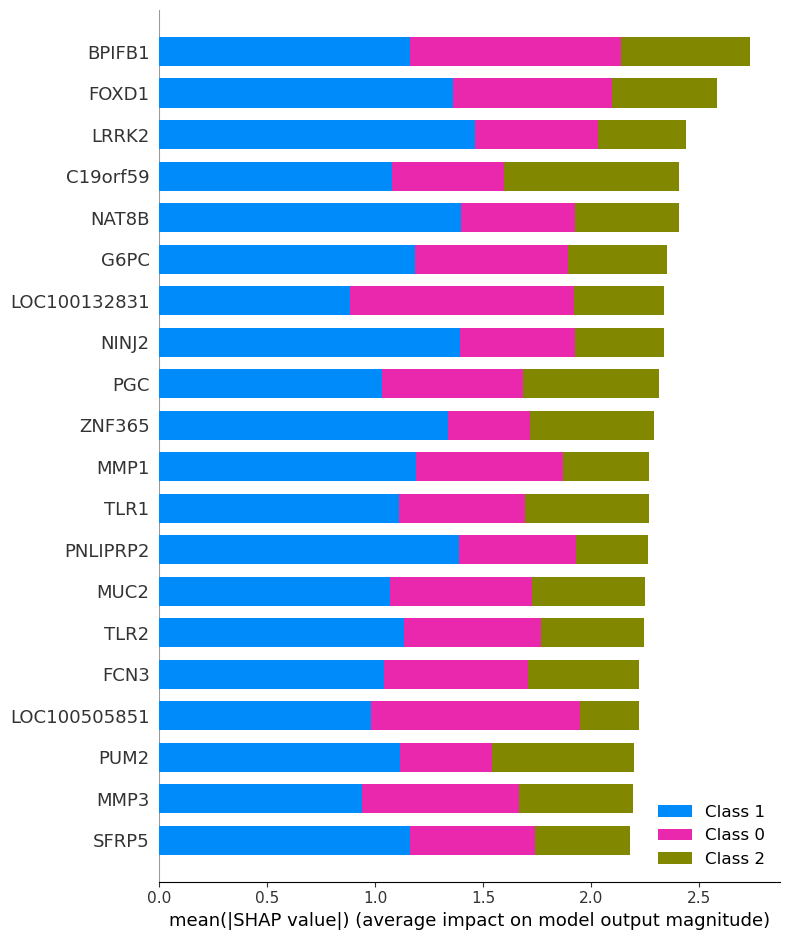

In [32]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


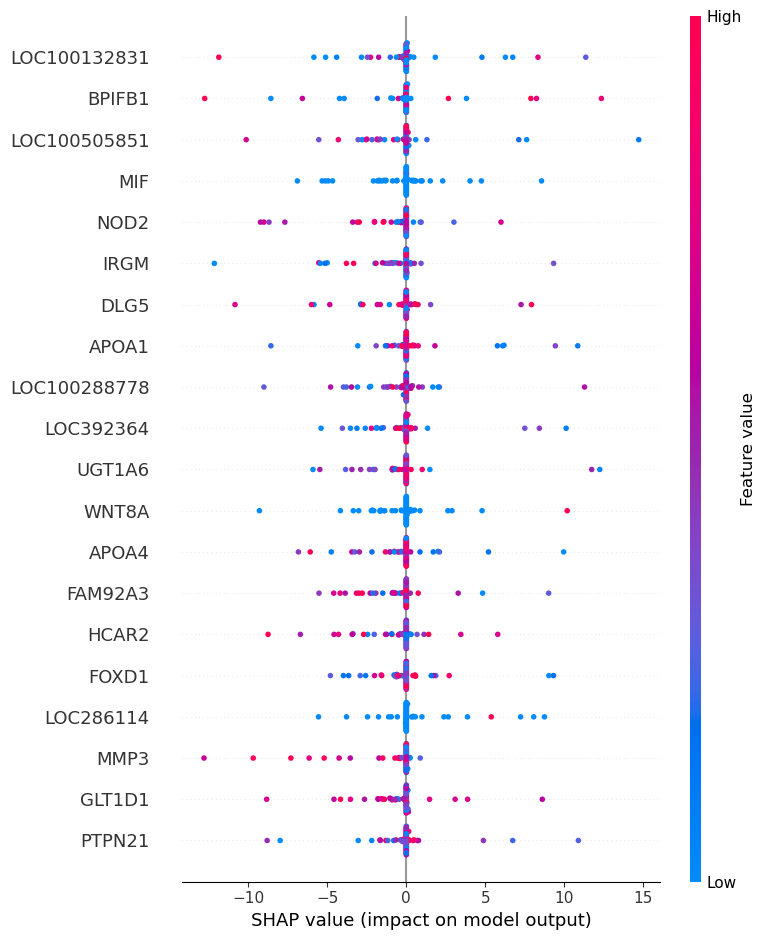

In [55]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

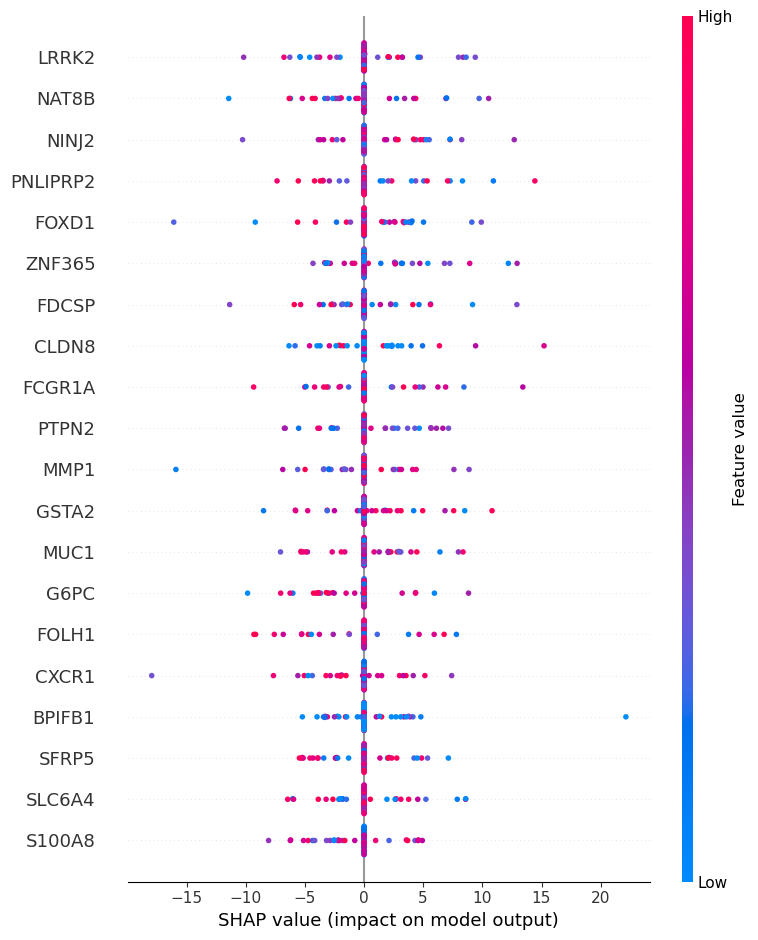

In [56]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

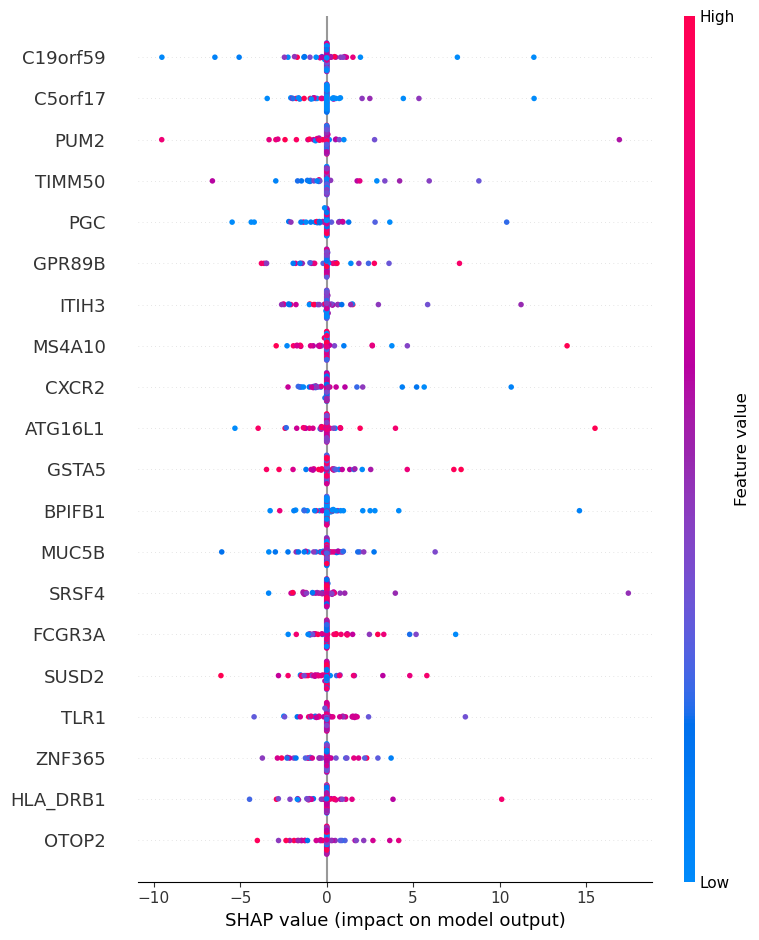

In [57]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

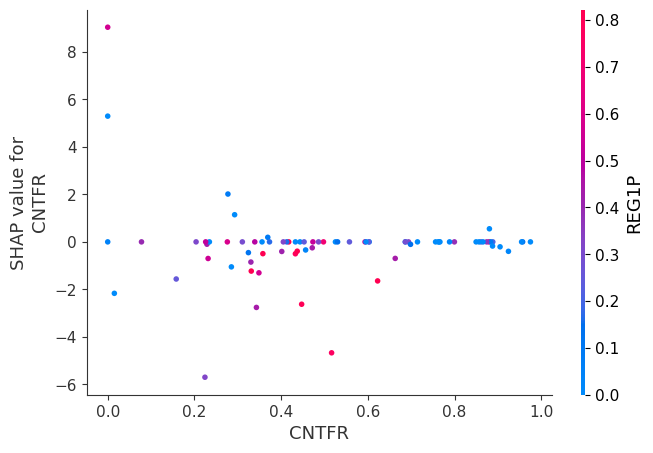

In [58]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

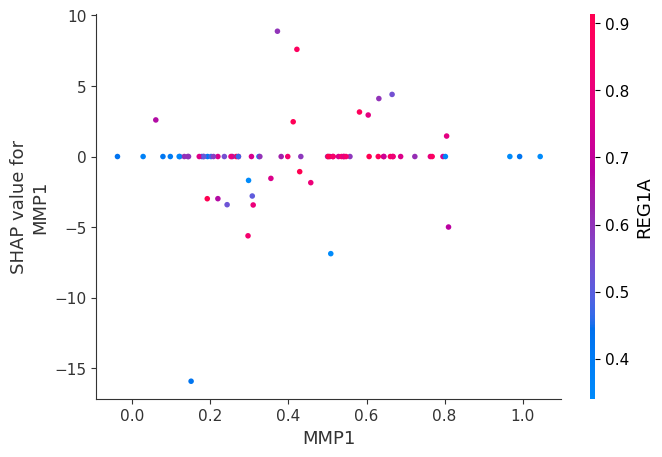

In [59]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

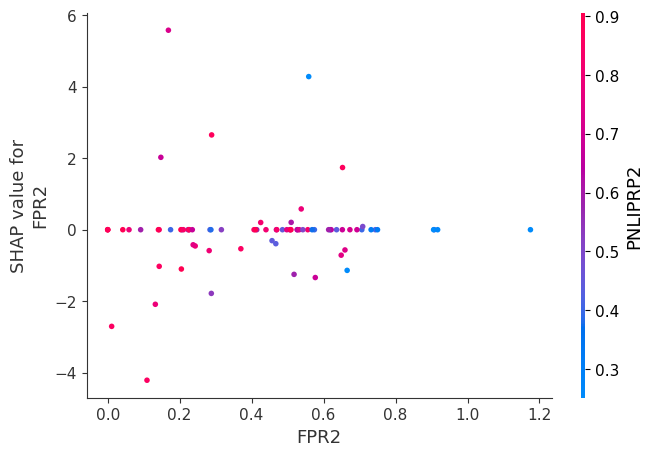

In [60]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [61]:
disease_labels_test.shape

(78,)

In [62]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [63]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 96%|█████████████████████████████████████████████████████████████████████████████   | 213/221 [01:24<00:02,  2.96it/s]No/low signal found from feature 212 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
222it [01:28,  2.20it/s]                                                                                               


In [64]:
# clustering

In [65]:
# clustering.shape

In [66]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [67]:
type(exp)

shap._explanation.Explanation

In [68]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [69]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

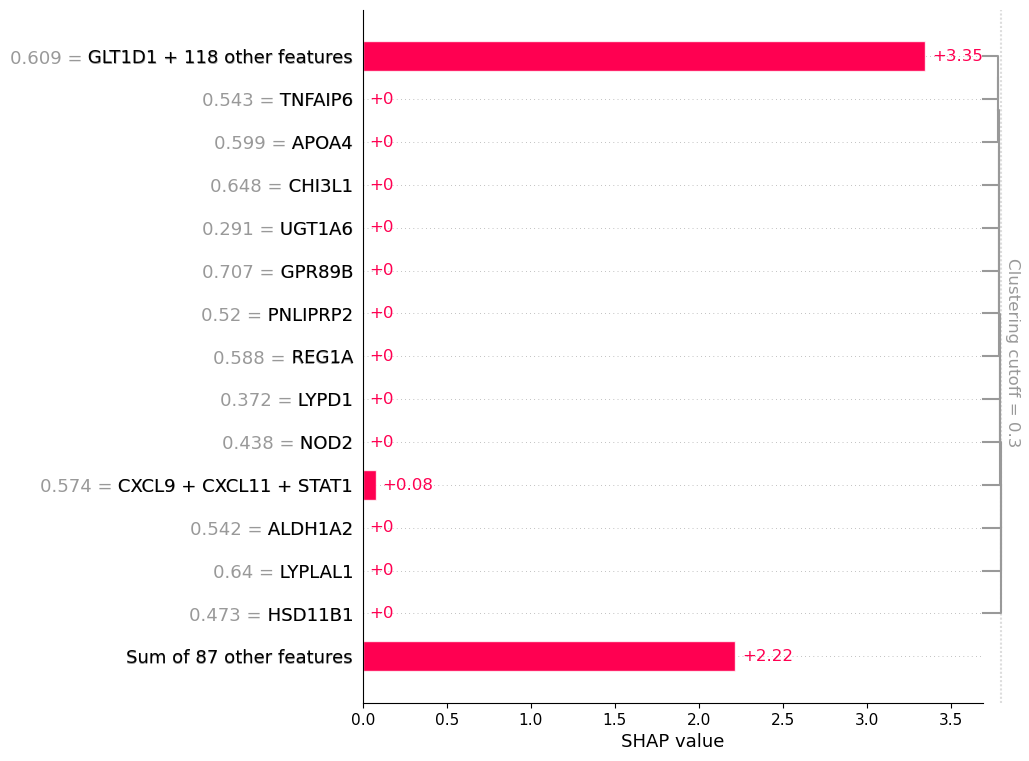

In [70]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [71]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [72]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203555
167_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,1.769848,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.483795,0.000000
196_CD_deep_ulcer,0.000000,0.000000,0.000000,0.895373,0.000000,0.000000,1.347169,0.000000,0.248559,0.000000,...,0.000000,0.995732,0.000000,0.000000,0.000000,0.084222,0.000000,0.000000,0.000000,0.113085
23_CD_deep_ulcer,0.000000,1.016589,0.273096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.336405,0.660652,0.000000,0.000000,0.000000,0.000000
93_CD_deep_ulcer,0.000000,-0.796222,-0.533561,-0.451392,0.280011,-0.294610,0.000000,-0.681701,0.000000,0.000000,...,0.000000,0.697456,0.000000,0.000000,-0.480167,0.000000,0.387955,-0.703139,1.026906,0.215752
229_CD_deep_ulcer,0.000000,0.000000,-0.732816,-0.457522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.260542,0.665357,0.000000,0.000000,-0.618872,0.265908,0.721095,-0.781804,0.000000,0.428316
46_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.236336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
176_CD_deep_ulcer,0.313031,0.581546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.377116,0.000000,0.321372,0.000000,0.325397,0.000000,0.454214,0.000000
49_CD_deep_ulcer,-0.881731,-0.937997,-2.201827,0.000000,0.000000,1.849498,0.000000,-1.514947,1.479252,0.000000,...,0.000000,0.000000,-0.858463,0.000000,0.000000,0.000000,-0.639346,0.000000,0.000000,0.000000


### Example: CD deep ulcer patients

In [73]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

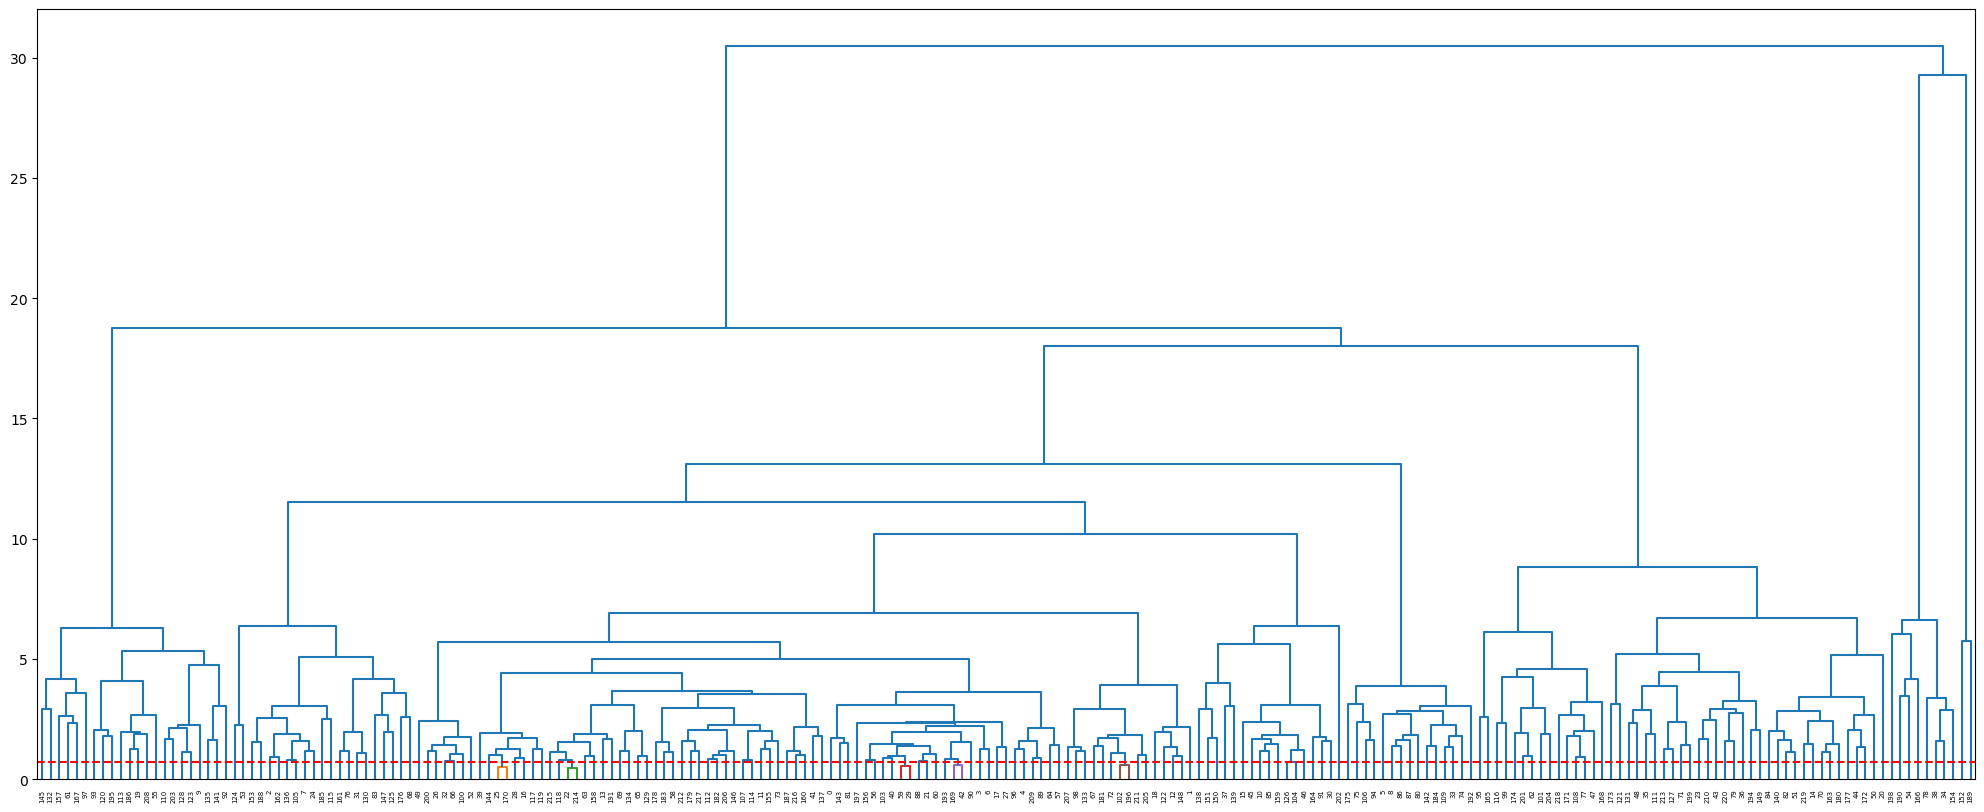

In [74]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [75]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([145, 132, 157,  61, 167,  97,  93, 120, 195, 113, 186,  19, 208,
        55, 110, 203, 128, 123,   9, 135, 141,  92, 124,  53, 153, 188,
         2, 162, 136, 105,   7,  24, 185, 115, 161,  76,  31, 130,  83,
       147, 125, 176,  68,  49, 200,  26,  32,  66, 100,  52,  39, 144,
        25, 170,  28,  16, 117, 119, 215, 118,  22, 214,  63, 158,  13,
       191,  69, 134,  65, 129, 178, 183,  58, 212, 179, 217, 112, 182,
       206, 146, 107, 114,  11, 155,  73, 187, 216, 160,  41, 137,   0,
       143,  81, 197, 156,  56, 103,  40,  59,  29,  88,  21,  60, 193,
       169,  42,  90,   3,   6,  17,  27,  96,   4, 209,  89,  64,  57,
       207,  98, 133,  67, 181,  72, 102, 196, 211, 205,  18, 122,  12,
       148,   1, 138, 151, 150,  37, 139,  15,  45,  10,  85, 159, 126,
       104,  46, 164,  91,  30, 202, 175,  75, 106,  94,   5,   8,  86,
        87,  80, 142, 184, 109,  33,  74, 192,  95, 165, 116,  99, 174,
       201,  62, 101, 204, 218, 171, 108,  77,  47, 168, 173, 12

In [76]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

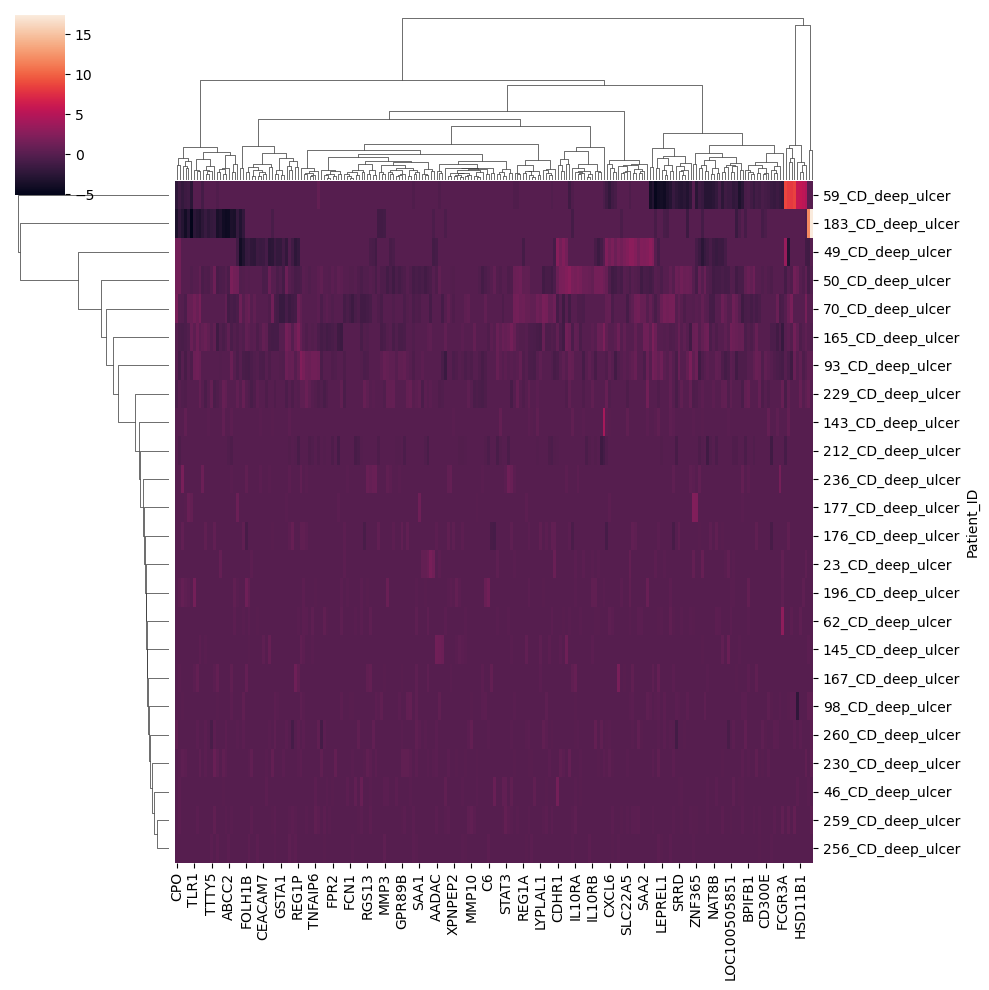

In [77]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [78]:
gene_cluster_cd_deep

array([[ 22.        , 214.        ,   0.45834112,   2.        ],
       [ 25.        , 170.        ,   0.51487316,   2.        ],
       [ 59.        ,  29.        ,   0.56494868,   2.        ],
       [169.        ,  42.        ,   0.58393025,   2.        ],
       [102.        , 196.        ,   0.59780392,   2.        ],
       [126.        , 104.        ,   0.70085386,   2.        ],
       [ 88.        ,  21.        ,   0.74686974,   2.        ],
       [ 32.        ,  66.        ,   0.7749287 ,   2.        ],
       [118.        , 221.        ,   0.78788962,   3.        ],
       [136.        , 105.        ,   0.79927499,   2.        ],
       [156.        ,  56.        ,   0.80772049,   2.        ],
       [107.        , 114.        ,   0.81299961,   2.        ],
       [112.        , 182.        ,   0.82885873,   2.        ],
       [193.        , 224.        ,   0.85001584,   3.        ],
       [103.        ,  40.        ,   0.86343352,   2.        ],
       [209.        ,  89

In [79]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [80]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([145, 132,  61, 167, 157,  97, 120, 195,  93, 186,  19, 208, 113,
         55, 110, 203, 128, 123,   9, 135, 141,  92, 124,  53, 153, 188,
          2, 162, 136, 105,   7,  24, 185, 115, 161,  76,  31, 130, 147,
        125,  83, 176,  68, 200,  26,  32,  66, 100,  52,  49, 144, 222,
         28,  16, 117, 119,  39, 118, 221, 215,  63, 158,  13, 191,  69,
        134,  65, 129, 183,  58, 178, 179, 217, 212, 112, 182, 206, 146,
        107, 114,  11, 155,  73, 216, 160, 187,  41, 137, 143,  81,   0,
        156,  56, 103,  40, 223,  88,  21,  60, 193, 224,  90,   3,   6,
        197,  17,  27,  96,   4, 209,  89,  64,  57,  98, 133, 207,  67,
        181,  72, 225, 211, 205,  12, 148, 122,  18,   1, 151, 150, 138,
         37, 139,  10,  85, 159,  45, 126, 104,  46,  15,  91,  30, 164,
        202, 106,  94,  75, 175,   8,  86,  87,  80,   5, 142, 184, 109,
         33,  74, 192,  95, 165, 116,  99, 201,  62, 174, 101, 204, 108,
         77, 171,  47, 218, 168, 173, 121, 131,  48

In [81]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  52,  51,
        53,  54,  55,  56,  57,  59,  58,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 101, 100, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 120, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [82]:
cluster_labels

array([ 91, 127,  27, 103, 109, 153, 104,  31, 149,  19, 133,  81, 123,
        63, 198, 140,  54, 106, 126,  11, 206,  98,  58, 185,  32,  51,
        45, 107,  53,  96, 142,  37,  46, 157, 212, 179, 190, 131, 211,
        57,  95,  87, 100, 187, 202, 136, 139, 172, 178,  50, 205, 194,
        49,  24, 208,  14,  93, 113,  70,  96,  99,   3, 165,  61, 112,
        67,  47, 117,  43,  65, 199, 183, 120,  83, 158, 147,  36, 170,
       214, 189, 152,  90, 193,  41, 196, 134, 150, 151,  97, 111, 102,
       141,  22,   9, 146, 160, 108,   6, 114, 163,  48, 167, 119,  94,
       138,  30, 145,  79, 169, 156,  15, 180,  75,  13,  80,  34, 162,
        55,  59,  56,   7, 176, 125,  18,  23,  40, 137, 182,  17,  68,
        38, 177,   2, 115,  66,  20,  29,  88, 130, 132, 195,  21, 154,
        89,  52,   1,  78,  39, 124, 192, 129, 128, 215,  25, 213,  82,
        92,   5,  62, 135,  85,  35,  28, 200, 143, 161, 209,   4, 174,
       100,  51, 171, 203, 175, 166, 148,  42, 204,  71,  72, 20

In [83]:
df_cd_deep.columns.get_loc("OSM")

63

In [84]:
np.where(cluster_labels == 2) #osm

(array([132], dtype=int64),)

In [85]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,0.037757,0.371415,-0.881731,0.0,0.0,0.00000,1.398269,AADAC,91
APOA1,24.0,0.001366,0.468742,-0.937997,0.0,0.0,0.00000,1.302928,APOA1,127
APOA4,24.0,-0.097934,0.506947,-2.201827,0.0,0.0,0.00000,0.563725,APOA4,27
APOB,24.0,0.004901,0.290281,-0.531609,0.0,0.0,0.00000,0.895373,APOB,103
APOC3,24.0,0.027020,0.194804,-0.408463,0.0,0.0,0.00000,0.659506,APOC3,109
...,...,...,...,...,...,...,...,...,...,...
C16orf78,24.0,-0.012402,0.297086,-1.189300,0.0,0.0,0.00000,0.660652,C16orf78,84
C5orf17,24.0,-0.063825,0.386606,-1.306046,0.0,0.0,0.00000,0.721095,C5orf17,73
LOC100132831,24.0,-0.181030,0.618670,-2.289270,0.0,0.0,0.00000,1.134502,LOC100132831,173
LOC100288778,24.0,0.052553,0.445634,-1.111437,0.0,0.0,0.00000,1.026906,LOC100288778,197


In [86]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.037757,91,AADAC
APOA1,0.001366,127,APOA1
APOA4,-0.097934,27,APOA4
APOB,0.004901,103,APOB
APOC3,0.027020,109,APOC3
...,...,...,...
C16orf78,-0.012402,84,C16orf78
C5orf17,-0.063825,73,C5orf17
LOC100132831,-0.181030,173,LOC100132831
LOC100288778,0.052553,197,LOC100288778


In [87]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.037757,91,AADAC
APOA1,0.001366,127,APOA1
APOA4,-0.097934,27,APOA4
APOB,0.004901,103,APOB
APOC3,0.027020,109,APOC3
...,...,...,...
C16orf78,-0.012402,84,C16orf78
C5orf17,-0.063825,73,C5orf17
LOC100132831,-0.181030,173,LOC100132831
LOC100288778,0.052553,197,LOC100288778


In [88]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [89]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [90]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [91]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-0.055211,1,[CPO]
2,-0.068206,1,[CYP4F11]
3,-0.267904,1,[MUC1]
4,-0.100056,1,[DUOXA2]
5,-0.108311,1,[FLJ35424]
...,...,...,...
212,0.199019,1,[HLA_B]
213,0.281343,1,[GSTA5]
214,0.228042,1,[SELE]


In [92]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.055211,1,[CPO],CPO
2,-0.068206,1,[CYP4F11],CYP4F11
3,-0.267904,1,[MUC1],MUC1
4,-0.100056,1,[DUOXA2],DUOXA2
5,-0.108311,1,[FLJ35424],FLJ35424
...,...,...,...,...
212,0.199019,1,[HLA_B],HLA_B
213,0.281343,1,[GSTA5],GSTA5
214,0.228042,1,[SELE],SELE


In [93]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [94]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.055211,1,[CPO],CPO
2,-0.068206,1,[CYP4F11],CYP4F11
5,-0.267904,1,[MUC1],MUC1
3,-0.100056,1,[DUOXA2],DUOXA2
4,-0.108311,1,[FLJ35424],FLJ35424
...,...,...,...,...
211,0.199019,1,[HLA_B],HLA_B
212,0.281343,1,[GSTA5],GSTA5
213,0.228042,1,[SELE],SELE
215,0.494381,1,[C19orf59],C19orf59


In [95]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.055211,1,[CPO],CPO
2,-0.068206,1,[CYP4F11],CYP4F11
3,-0.100056,1,[DUOXA2],DUOXA2
4,-0.108311,1,[FLJ35424],FLJ35424
5,-0.267904,1,[MUC1],MUC1
...,...,...,...,...
212,0.281343,1,[GSTA5],GSTA5
213,0.228042,1,[SELE],SELE
214,0.298036,1,[HSD11B1],HSD11B1
215,0.494381,1,[C19orf59],C19orf59


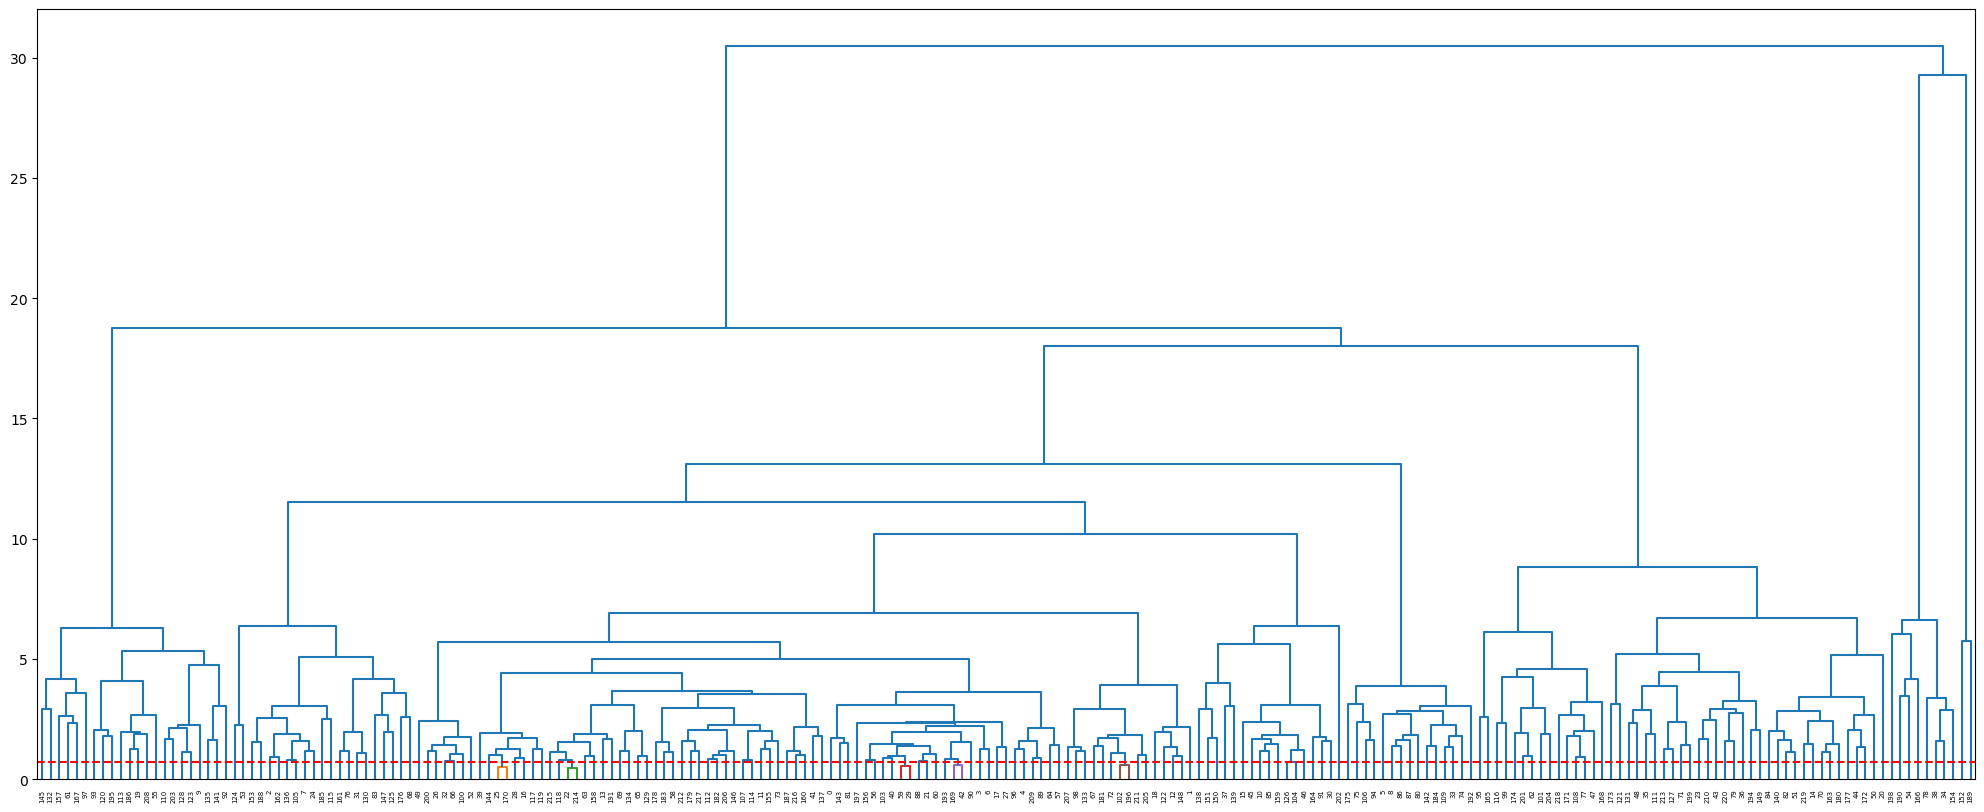

In [96]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

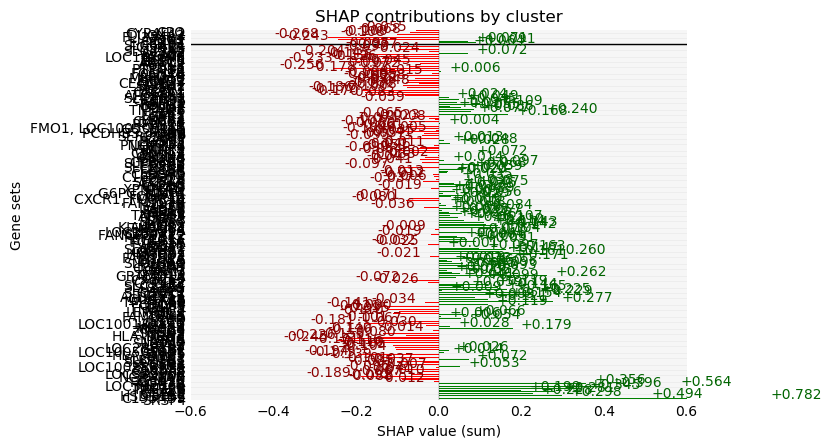

In [97]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [98]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [99]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

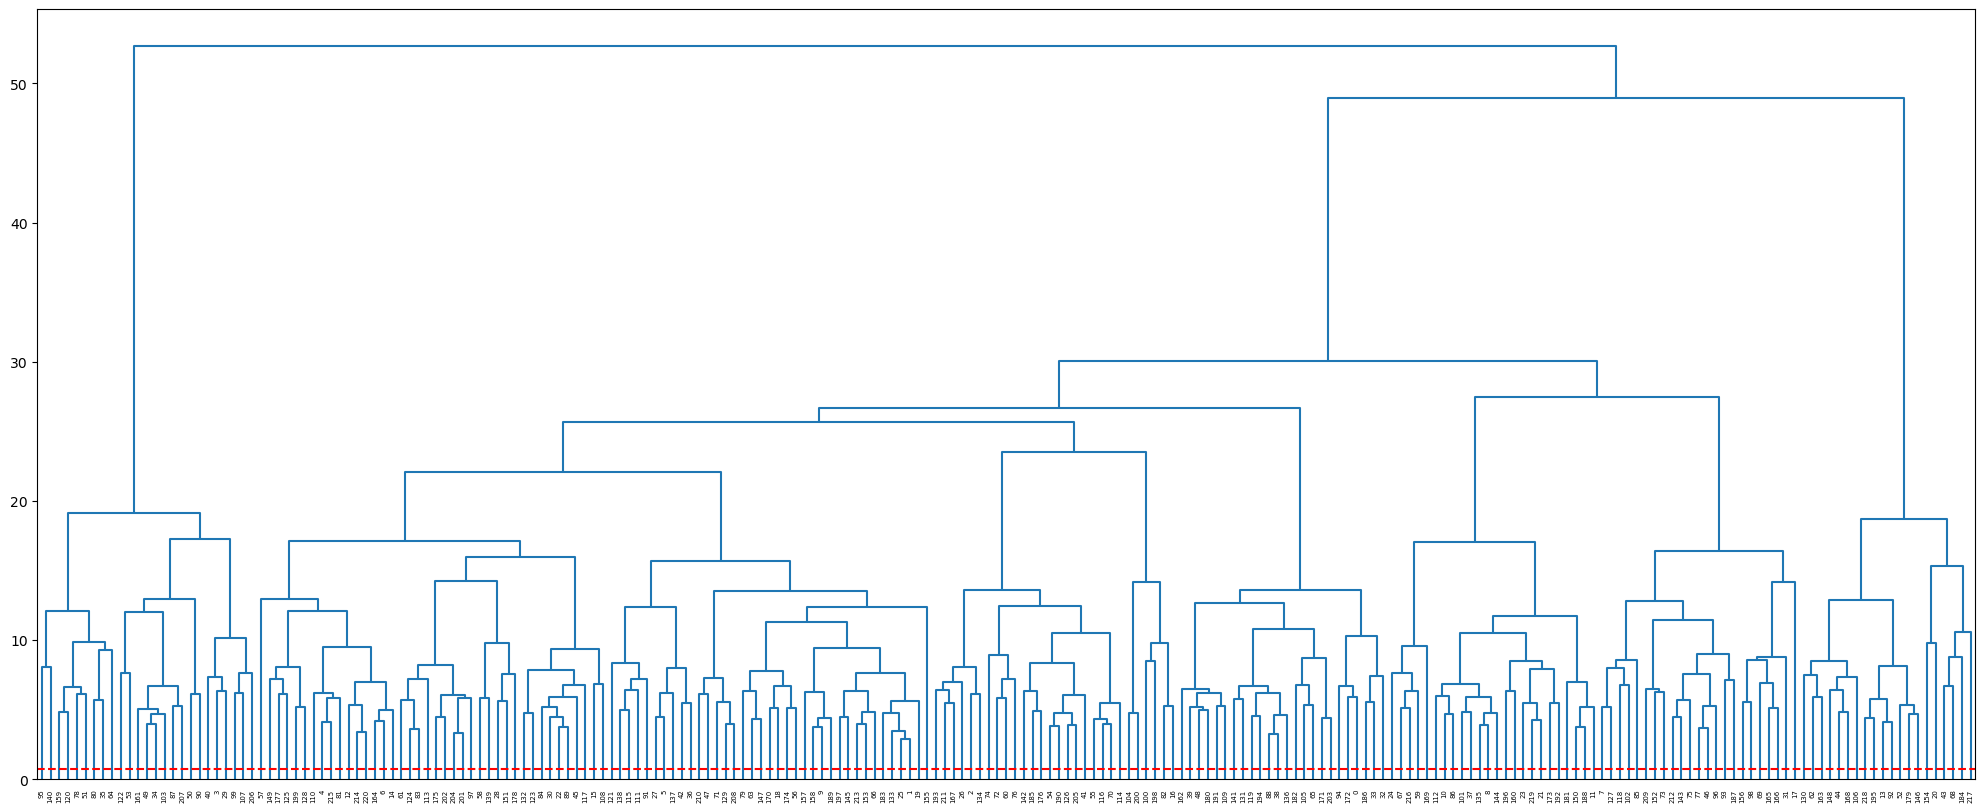

In [100]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [101]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 95, 140, 159, 120,  78,  51,  80,  35,  64, 122,  53, 161,  49,
        34, 103,  87, 207,  50,  90,  40,   3,  29,  99, 107, 206,  57,
       149, 177, 125, 199, 128, 110,   4, 215,  81,  12, 214, 220, 164,
         6,  14,  61, 124,  83, 113, 175, 202, 204, 201,  97,  58, 139,
        28, 151, 178, 132, 123,  84,  30,  22,  89,  45, 117,  15, 108,
       121, 138, 115, 111,  91,  27,   5, 137,  42,  36, 210,  47,  71,
       129, 208,  79,  63, 147, 170,  18, 174,  56, 157, 158,   9, 189,
       197, 145, 213, 153,  66, 183, 133,  25,   1,  19, 155, 193, 211,
       167,  26,   2, 134,  74,  72,  60,  76, 142, 185, 176,  54, 190,
       126, 205,  41,  55, 116,  70, 114, 104, 200, 100, 198,  82,  16,
       162,  39,  48, 180, 191, 109, 141, 131, 119, 194,  88,  38, 136,
       182, 105,  65, 171, 203,  94, 172,   0, 186,  33,  32,  24,  67,
       216,  59, 169, 112,  10,  86, 101,  37, 135,   8, 144, 196, 160,
        23, 219,  21, 173, 192, 181, 150, 188,  11,   7, 127, 11

In [102]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

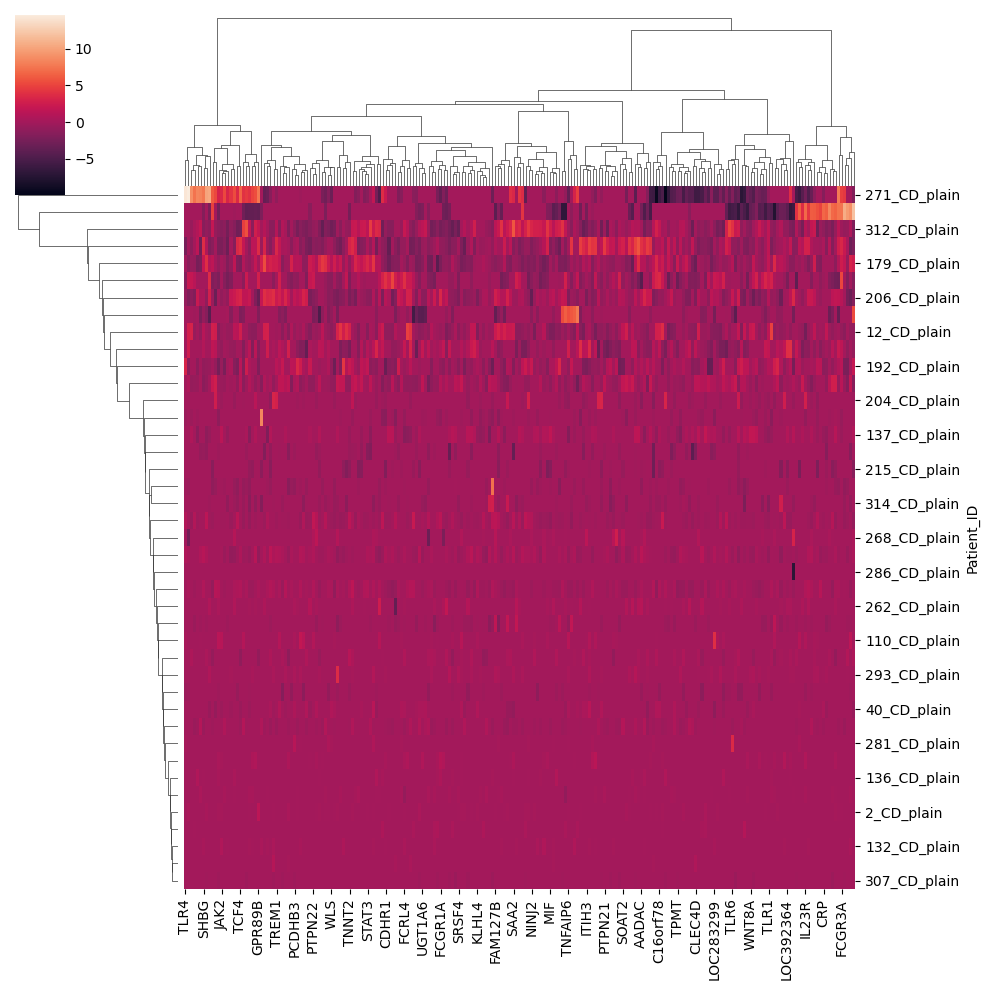

In [103]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [104]:
gene_cluster_cd_plain

array([[ 25.        ,   1.        ,   2.85149239,   2.        ],
       [ 88.        ,  38.        ,   3.22860357,   2.        ],
       [204.        , 201.        ,   3.34828754,   2.        ],
       [214.        , 220.        ,   3.35980326,   2.        ],
       [133.        , 221.        ,   3.43955427,   3.        ],
       [124.        ,  83.        ,   3.57259866,   2.        ],
       [ 77.        ,  46.        ,   3.64868843,   2.        ],
       [ 22.        ,  89.        ,   3.73087476,   2.        ],
       [158.        ,   9.        ,   3.74596057,   2.        ],
       [150.        , 188.        ,   3.77883035,   2.        ],
       [ 54.        , 190.        ,   3.85371297,   2.        ],
       [126.        , 205.        ,   3.87191501,   2.        ],
       [135.        ,   8.        ,   3.91212066,   2.        ],
       [129.        , 208.        ,   3.94664127,   2.        ],
       [116.        ,  70.        ,   3.94704418,   2.        ],
       [ 49.        ,  34

In [105]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [106]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([ 95, 140, 159, 120,  78,  51,  80,  35,  64, 122,  53,  49,  34,
        103, 161,  87, 207,  50,  90,   3,  29,  40,  99, 107, 206, 177,
        125, 149, 199, 128,   4, 215,  81, 110, 214, 220,  12, 164,   6,
         14,  57, 124,  83,  61, 113, 175, 202, 204, 201,  97,  58, 139,
         28, 151, 178, 132, 123,  22,  89,  30,  84,  45, 117,  15, 108,
        138, 115, 111,  91, 121,  27,   5, 137,  42,  36, 210,  47, 129,
        208,  71,  63, 147,  79, 170,  18, 174,  56, 158,   9, 189, 157,
        197, 145, 213, 153,  66,  25,   1, 133, 183,  19, 155, 211, 167,
        193,  26,   2, 134,  72,  60,  76,  74, 185, 176, 142,  54, 190,
        126, 205,  41, 116,  70,  55, 114, 104, 200, 100, 198,  82,  16,
         48, 180,  39, 191, 109, 162, 141, 131, 119, 194,  88,  38, 136,
        105,  65, 182, 171, 203, 172,   0,  94, 186,  33,  32,  67, 216,
         59,  24, 169,  10,  86, 112, 101,  37, 135,   8, 144, 196, 160,
        219,  21,  23, 173, 192, 150, 188,  11, 181

In [107]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [108]:
cluster_labels

array([150,  98, 107,  20,  31,  72,  39, 179, 166,  89, 160, 177,  37,
       211,  40,  64, 130, 201,  85, 101, 217, 171,  58, 172, 158,  97,
       106,  71,  53,  21,  60, 200, 154, 153,  13,   8,  75, 164, 142,
       133,  22, 120,  74, 218, 205,  62, 191,  77, 131,  12,  18,   6,
       215,  11, 116, 123,  87,  41,  51, 157, 110,  44, 202,  81,   9,
       145,  96, 155, 219, 199, 122,  80, 109, 185, 112, 189, 111, 190,
         5,  83,   7,  33, 129,  43,  61, 183, 161,  16, 141,  59,  19,
        69, 212, 193, 151,   1, 192,  50, 196,  23, 127, 163, 182,  14,
       125, 144, 208,  24,  65, 135,  34,  68, 162,  45, 124,  67, 121,
        63, 181, 139,   4,  70,  10,  57,  42,  27, 118, 180,  30,  78,
       204, 138,  56,  99, 108, 165, 143,  73,  66,  52,   2, 137, 115,
       188, 167,  93, 214,  82, 207,  28, 175,  54, 184,  95, 216, 102,
       195,  91,  88,   3, 169,  15, 136, 203,  38, 197, 198, 104, 206,
       159,  84, 147, 149, 173,  86,  46, 114,  26,  55, 213, 13

In [109]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,-0.006124,1.146106,-4.369885,0.000000,0.0,0.0,4.013844,AADAC,150
APOA1,41.0,-0.080839,0.368761,-1.509704,0.000000,0.0,0.0,0.732235,APOA1,98
APOA4,41.0,0.173745,0.990493,-1.765719,0.000000,0.0,0.0,2.857093,APOA4,107
APOB,41.0,0.271005,1.401526,-3.723784,0.000000,0.0,0.0,5.668795,APOB,20
APOC3,41.0,0.032090,0.703763,-1.683016,0.000000,0.0,0.0,2.010204,APOC3,31
...,...,...,...,...,...,...,...,...,...,...
C16orf78,41.0,0.113931,1.321261,-6.081900,0.000000,0.0,0.0,3.566655,C16orf78,156
C5orf17,41.0,0.199344,2.276771,-2.077614,-0.558465,0.0,0.0,11.988662,C5orf17,221
LOC100132831,41.0,-0.017378,1.132809,-2.921345,0.000000,0.0,0.0,5.526339,LOC100132831,209
LOC100288778,41.0,-0.233923,0.953442,-5.167759,-0.367965,0.0,0.0,1.268197,LOC100288778,170


In [110]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-0.006124,150,AADAC
APOA1,-0.080839,98,APOA1
APOA4,0.173745,107,APOA4
APOB,0.271005,20,APOB
APOC3,0.032090,31,APOC3
...,...,...,...
C16orf78,0.113931,156,C16orf78
C5orf17,0.199344,221,C5orf17
LOC100132831,-0.017378,209,LOC100132831
LOC100288778,-0.233923,170,LOC100288778


In [111]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-0.006124,150,AADAC
APOA1,-0.080839,98,APOA1
APOA4,0.173745,107,APOA4
APOB,0.271005,20,APOB
APOC3,0.032090,31,APOC3
...,...,...,...
C16orf78,0.113931,156,C16orf78
C5orf17,0.199344,221,C5orf17
LOC100132831,-0.017378,209,LOC100132831
LOC100288778,-0.233923,170,LOC100288778


In [112]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,0.332559,1,[TLR4]
2,0.381066,1,[BPIFB1]
3,0.232005,1,[FAM151A]
4,0.104997,1,[SLC6A14]
5,0.171330,1,[SELE]
...,...,...,...
217,0.634761,1,[FCGR3A]
218,0.272112,1,[CXCR2]
219,-0.041464,1,[REG1P]


In [113]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,0.332559,1,[TLR4],TLR4
2,0.381066,1,[BPIFB1],BPIFB1
3,0.232005,1,[FAM151A],FAM151A
4,0.104997,1,[SLC6A14],SLC6A14
5,0.171330,1,[SELE],SELE
...,...,...,...,...
217,0.634761,1,[FCGR3A],FCGR3A
218,0.272112,1,[CXCR2],CXCR2
219,-0.041464,1,[REG1P],REG1P


In [114]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [115]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,0.332559,1,[TLR4],TLR4
2,0.381066,1,[BPIFB1],BPIFB1
3,0.232005,1,[FAM151A],FAM151A
4,0.104997,1,[SLC6A14],SLC6A14
5,0.171330,1,[SELE],SELE
...,...,...,...,...
217,0.634761,1,[FCGR3A],FCGR3A
218,0.272112,1,[CXCR2],CXCR2
219,-0.041464,1,[REG1P],REG1P
220,0.154949,1,[CLVS1],CLVS1


In [116]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,0.332559,1,[TLR4],TLR4
2,0.381066,1,[BPIFB1],BPIFB1
3,0.232005,1,[FAM151A],FAM151A
4,0.104997,1,[SLC6A14],SLC6A14
5,0.171330,1,[SELE],SELE
...,...,...,...,...
217,0.634761,1,[FCGR3A],FCGR3A
218,0.272112,1,[CXCR2],CXCR2
219,-0.041464,1,[REG1P],REG1P
220,0.154949,1,[CLVS1],CLVS1


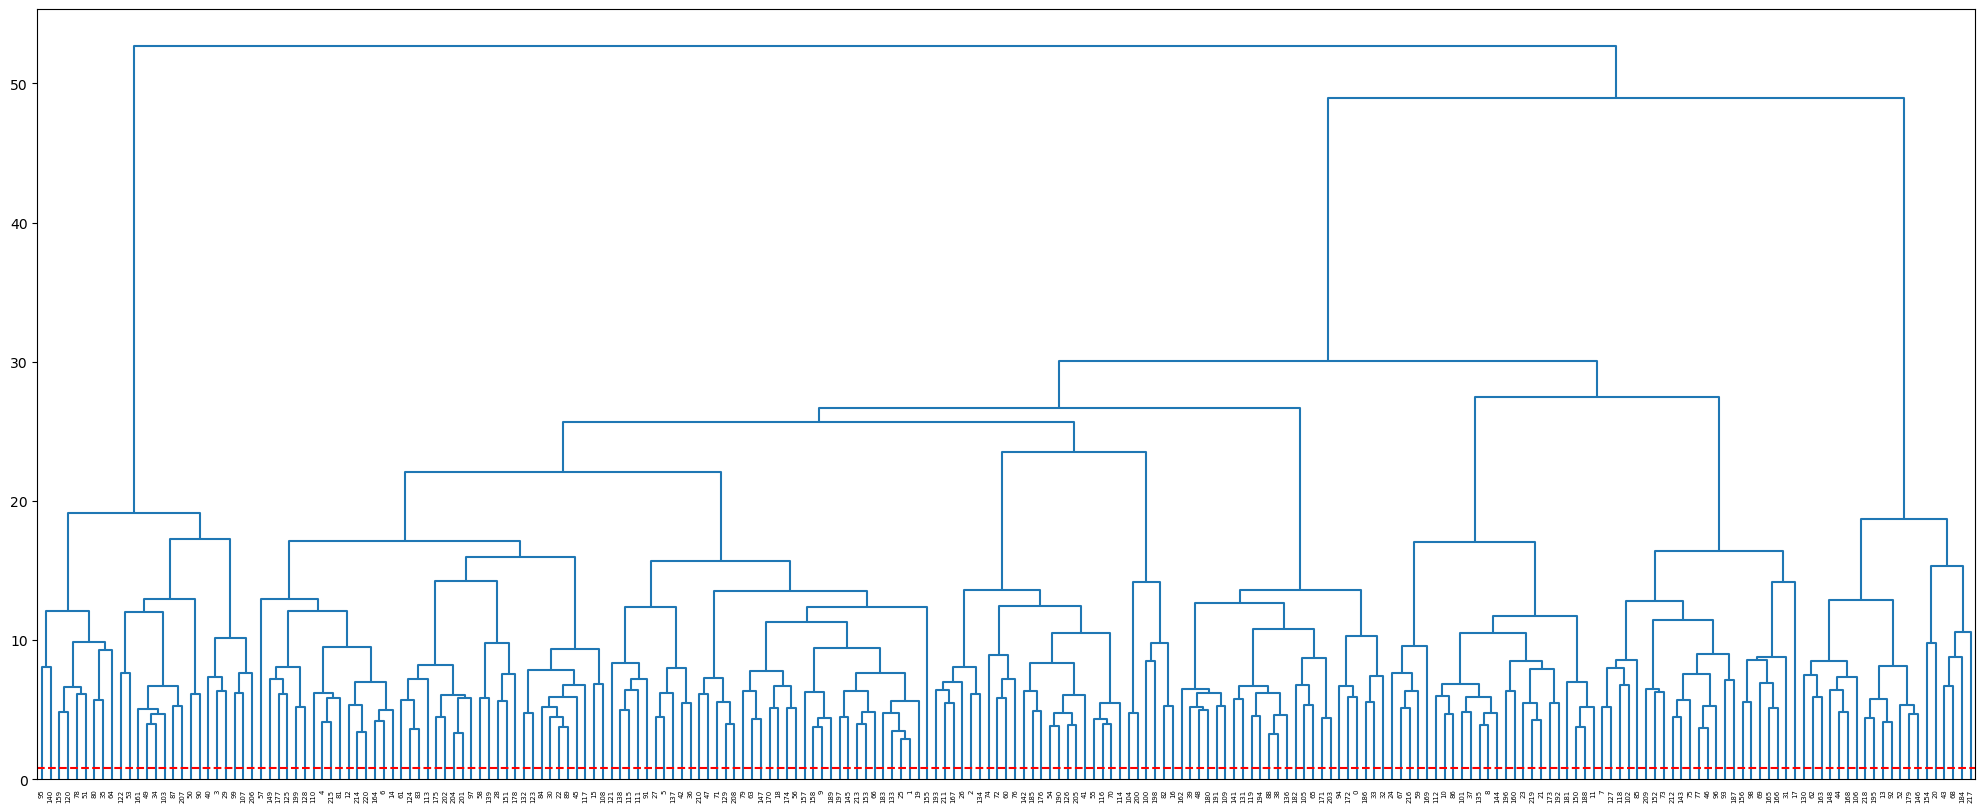

In [117]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

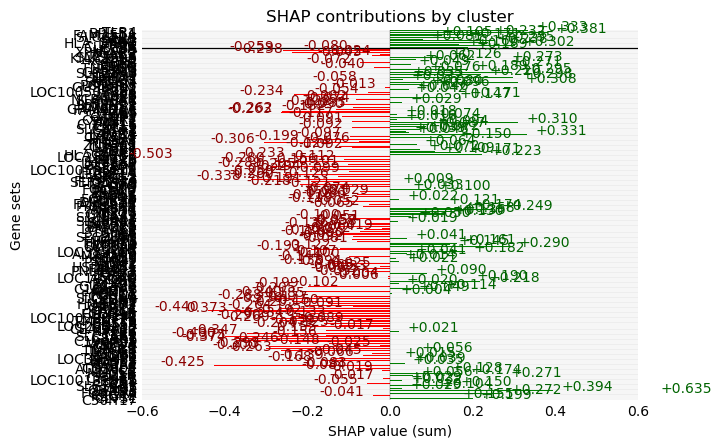

In [118]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [119]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")